In [1]:
import pandas as pd

In [84]:
data = pd.read_csv('./GrammarandProductReviews.csv')

In [4]:
data.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


In [8]:
list(data.columns)

['id',
 'brand',
 'categories',
 'dateAdded',
 'dateUpdated',
 'ean',
 'keys',
 'manufacturer',
 'manufacturerNumber',
 'name',
 'reviews.date',
 'reviews.dateAdded',
 'reviews.dateSeen',
 'reviews.didPurchase',
 'reviews.doRecommend',
 'reviews.id',
 'reviews.numHelpful',
 'reviews.rating',
 'reviews.sourceURLs',
 'reviews.text',
 'reviews.title',
 'reviews.userCity',
 'reviews.userProvince',
 'reviews.username',
 'upc']

In [9]:
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating
count,3.215800e+04,32508.000000,71044.000000
mean,7.944753e+07,0.410422,4.385747
std,4.842696e+07,3.574442,1.067659
min,2.187400e+04,0.000000,1.000000
25%,3.355342e+07,0.000000,4.000000
50%,7.124763e+07,0.000000,5.000000
75%,1.112628e+08,0.000000,5.000000
max,1.038227e+09,183.000000,5.000000


In [13]:
import matplotlib.pyplot as plt

(array([ 3701.,     0.,  1833.,     0.,     0.,  4369.,     0., 14598.,
            0., 46543.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

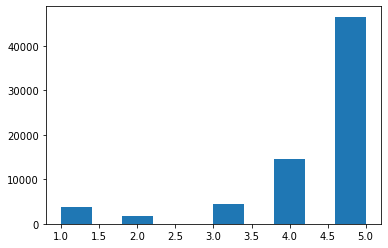

In [14]:
plt.hist(data['reviews.rating'])

Podemos observar que hay 25 columnas en el dataset. De estas, solo reviews.id, reviews.numHelpful y reviews.rating son numéricas. Podemos observar además que, dado que la mediana de reviews.rating es 5 y que el promedio es 4.38, que más de la mitad de reseñas son de 5 estrellas, y al menos un 75% del dataset tiene reseñas por encima de 4 estrellas.
Por otro lado, parece que poca gente indica si una reseña de alguien más es útil.

Con los ratings (e incluso los títulos), ya se puede tener una idea del contenido del review.

In [81]:
import re
import numpy as np
import string

REPLACE_NO_SPACE = re.compile(r"[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile(r"(<br\s*/><br\s*/>)|(\-)|(\/)(.)")

def RemoveWithRegex(words):
    x = np.copy(words)
    punctuation = r'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for i in range(len(x)):
        x[i] = REPLACE_NO_SPACE.sub("", str(x[i]))
        x[i] = REPLACE_WITH_SPACE.sub(" ", str(x[i]))
        x[i] = "".join(filter(lambda x: not x.isdigit(), x[i])) # Quitar digitos
        x[i] = ' '.join(word.strip(string.punctuation) for word in x[i].split()) # última línea de defensa
    return x

In [85]:
data['reviews.text'] = data['reviews.text'].str.lower()
data['reviews.title'] = data['reviews.title'].str.lower()

In [86]:
data['reviews.text'] = RemoveWithRegex(np.asarray(data['reviews.text']))
data['reviews.title'] = RemoveWithRegex(np.asarray(data['reviews.title']))

In [91]:
import nltk
nltk.download('stopwords')
english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [92]:
data['reviews.text'] = remove_stop_words(np.asarray(data['reviews.text']))
data['reviews.title'] = remove_stop_words(np.asarray(data['reviews.title']))

Ya que hemos limpiado el texto de las reseñas y los títulos de las mismas, vale la pena evaluar cuáles son las palabras más usadas. Además, esto se hará distinguiendo con respecto al rating otorgado.

In [97]:
rated_1 = data[data['reviews.rating'] == 1]
rated_2 = data[data['reviews.rating'] == 2]
rated_3 = data[data['reviews.rating'] == 3]
rated_4 = data[data['reviews.rating'] == 4]
rated_5 = data[data['reviews.rating'] == 5]